
Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Aug 31 05:45:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv5

In [4]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

## Install YOLOv8

In [5]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.167 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## Install Detectron2

In [6]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


## Install Supervision

In [7]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


## Download data

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 35.1MB/s]


In [10]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-8-31 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 270M/270M [00:05<00:00, 49.3MB/s]

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


In [11]:
import numpy as np

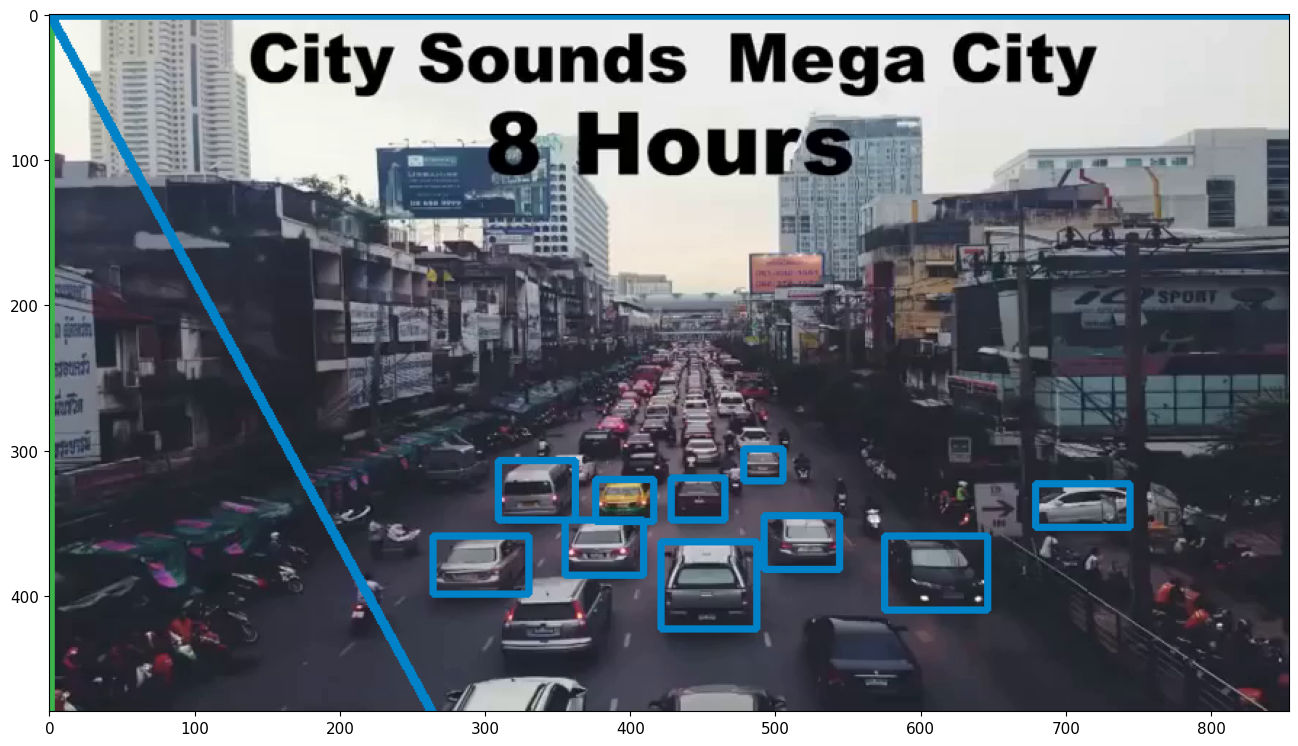

In [17]:
colors = sv.ColorPalette.default()
polygons = [
    np.array([
        [540,  985 ],
        [1620, 985 ],
        [2160, 1920],
        [1620, 2855],
        [540,  2855],
        [0,    1920]
    ], np.int32),
    np.array([
        [0,    1920],
        [540,  985 ],
        [0,    0   ]
    ], np.int32),
    np.array([
        [1620, 985 ],
        [2160, 1920],
        [2160,    0]
    ], np.int32),
    np.array([
        [540,  985 ],
        [0,    0   ],
        [2160, 0   ],
        [1620, 985 ]
    ], np.int32),
    np.array([
        [0,    1920],
        [0,    3840],
        [540,  2855]
    ], np.int32),
    np.array([
        [2160, 1920],
        [1620, 2855],
        [2160, 3840]
    ], np.int32),
    np.array([
        [1620, 2855],
        [540,  2855],
        [0,    3840],
        [2160, 3840]
    ], np.int32)
]
video_info = sv.VideoInfo.from_video_path("/content/City Sounds - Mega City - Traffic, Horns, People, Ambience.mp4")

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=6,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]
# extract video frame
generator = sv.get_video_frames_generator("/content/City Sounds - Mega City - Traffic, Horns, People, Ambience.mp4")
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, size=6000)
detections = sv.Detections.from_yolov5(results)
detections = detections[(detections.class_id ==2 ) & (detections.confidence > 0.5)]

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
    frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [13]:
len(detections)

10